# Trabajo Clustering
El objetivo de este trabajo es la realización de un estudio de *clustering* teniendo en cuenta los datos relativos a una encuentra sobre el transporte llevada a cabo en Alemania entre los años 2010 y 2012. La técnica utilizada será Fuzzy C Means.

## Lectura y Visualización de los Datos

In [1]:
# Importación del paquete Pandas para la lectura del archivo.
import pandas as pd

In [2]:
# Carga del archivo con los datos.
data = pd.read_csv("./nts_data.csv")

In [3]:
# Visualización de los primeros registros.
data.head(5)

,mode_main,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind
0,walk,1.0,1.26259,84,no,native,lower,less20,0,yes,1,yes,1.24604,26.881233,0.1,0.10,3.0
1,walk,10.0,1.26259,84,no,native,lower,less20,0,yes,1,yes,1.24604,26.881233,0.1,0.10,3.0
2,car,3.0,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8
3,car,3.0,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8
4,car,61.5,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8


In [4]:
print ("Características iniciales: " + str(len(data.columns)))
print ("Registros totales: " + str(len(data.index)))

Características iniciales: 17
Registros totales: 230608


In [5]:
# Visualización de los tipos de datos contenidos en el archivo inicial.
data.dtypes

mode_main     object
distance     float64
density      float64
age            int64
male          object
ethnicity     object
education     object
income        object
cars           int64
license       object
bicycles       int64
weekend       object
diversity    float64
green        float64
temp         float64
precip       float64
wind         float64
dtype: object

Como se puede observar en el resultado de la ejecución de código anterior, existen diferentes tipos de valores en el archivo. No todos son de tipo numérico, sino que también se encuentran datos de tipo categórico. Estos datos deberán transformarse para su posterior tratamiento a lo largo de este trabajo.

In [6]:
# Visualización de las variables categóricas junto con el total de los diferentes valores que toma cada una.
catchar = list(data.select_dtypes(include=['object']))

for value in range(len(catchar)):
    print ("Valores diferentes para la característica '" + catchar[value] + "':")
    print data[catchar[value]].value_counts()
    
    if value != len(catchar) - 1:
        print ("\n")

Valores diferentes para la característica 'mode_main':
car     127439
bike     56298
walk     37571
pt        9300
Name: mode_main, dtype: int64


Valores diferentes para la característica 'male':
no     125676
yes    104932
Name: male, dtype: int64


Valores diferentes para la característica 'ethnicity':
native        201561
western        17772
nonwestern     11275
Name: ethnicity, dtype: int64


Valores diferentes para la característica 'education':
middle    88306
higher    79185
lower     63117
Name: education, dtype: int64


Valores diferentes para la característica 'income':
more40    106182
20to40     97140
less20     27286
Name: income, dtype: int64


Valores diferentes para la característica 'license':
yes    206986
no      23622
Name: license, dtype: int64


Valores diferentes para la característica 'weekend':
no     189250
yes     41358
Name: weekend, dtype: int64


De esta manera, se observa que no existen datos nulos, por lo que no es necesaria su modificación.

In [7]:
# Obtención de datos estadísticos de las variables numéricas iniciales.
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance,230608.0,12.217913,23.545686,0.10000,1.50000,4.000000,12.000000,400.000000
density,230608.0,1.569055,1.593292,0.00184,0.59132,1.153210,1.952960,11.442960
age,230608.0,47.661356,15.934884,18.00000,36.00000,47.000000,60.000000,98.000000
cars,230608.0,1.382584,0.822056,0.00000,1.00000,1.000000,2.000000,10.000000
bicycles,230608.0,3.357134,1.936614,0.00000,2.00000,3.000000,4.000000,10.000000
diversity,230608.0,1.774927,0.493037,0.00000,1.38894,1.827390,2.172380,2.827560
green,230608.0,54.939470,22.172372,0.00000,37.11120,54.102123,74.381844,97.813002
temp,230608.0,13.316930,7.565732,-9.00000,8.00000,13.400000,19.000000,35.900000
precip,230608.0,2.184633,4.674801,0.00000,0.00000,0.100000,2.300000,142.300000
wind,230608.0,4.097702,1.914821,0.40000,2.70000,3.800000,5.100000,16.300000


## Tratamiento de los Datos Iniciales
Una vez que se dispone de una visualización rápida de la estructura del archivo, se procede a realizar algunas transformaciones para la homogeneización de los datos.
Puesto que existen valores categóricos en alguna de las características, se procederá a su transformación numérica con respecto a unas reglas que se explican a continuación.
En el caso de que sean características cuyos valores tomen valores 'sí'/'no', se asignarán valores numéricos '1'/'0', respectivamente.

Por otra parte, en el caso de que las características tengan diferentes valores, se asignarán valores ascendentes (1, 2, 3, ...). De esta manera, aunque las características 'mode_main' o 'ethnicity' no tendrían demasiado sentido en la posterior homogeneización, las características 'education' e 'income' se verían mejor representadas, ya que conforme el nivel de educación o de ingresos sea mayor, el valor irá en aumento consecuentemente.

In [8]:
# Transformación de las características binarias (sí-no).
data['male'] = data['male'].map({'yes': 1, 'no': 0})
data['license'] = data['license'].map({'yes': 1, 'no': 0})
data['weekend'] = data['weekend'].map({'yes': 1, 'no': 0})

In [9]:
# Transformación del resto de características no numéricas.
data['mode_main'] = data['mode_main'].map({'bike': 1, 'car': 2, 'pt': 3, 'walk': 4})
data['ethnicity'] = data['ethnicity'].map({'native': 1, 'nonwestern': 2, 'western': 3})
data['education'] = data['education'].map({'lower': 1, 'middle': 2, 'higher': 3})
data['income'] = data['income'].map({'less20': 1, '20to40': 2, 'more40': 3})

In [10]:
# Comprobación de la correcta modificación de los datos.
data.head(5)

,mode_main,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind
0,4,1.0,1.26259,84,0,1,1,1,0,1,1,1,1.24604,26.881233,0.1,0.10,3.0
1,4,10.0,1.26259,84,0,1,1,1,0,1,1,1,1.24604,26.881233,0.1,0.10,3.0
2,2,3.0,1.76264,27,1,3,2,2,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8
3,2,3.0,1.76264,27,1,3,2,2,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8
4,2,61.5,1.76264,27,1,3,2,2,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8


A continuación, estandarizamos todos los datos para que tengan una igual relevancia en los cálculos posteriores. Para ello, se utilizará el método "MinMaxScaler", ya que es uno de los métodos más sensible a outliers.

In [11]:
# Importación de paquetes necesarios para la estandarización
from sklearn import preprocessing

In [12]:
#x = data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data)
df_scaled = pd.DataFrame(x_scaled, columns=list(data))
df_scaled.head(5)

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,mode_main,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind
0,1.000000,0.002251,0.110195,0.8250,0.0,0.0,0.0,0.0,0.0,1.0,0.1,1.0,0.440677,0.274823,0.202673,0.000703,0.163522
1,1.000000,0.024756,0.110195,0.8250,0.0,0.0,0.0,0.0,0.0,1.0,0.1,1.0,0.440677,0.274823,0.202673,0.000703,0.163522
2,0.333333,0.007252,0.153901,0.1125,1.0,1.0,0.5,0.5,0.1,1.0,0.2,1.0,0.544494,0.368519,0.124722,0.000351,0.088050
3,0.333333,0.007252,0.153901,0.1125,1.0,1.0,0.5,0.5,0.1,1.0,0.2,1.0,0.544494,0.368519,0.124722,0.000351,0.088050
4,0.333333,0.153538,0.153901,0.1125,1.0,1.0,0.5,0.5,0.1,1.0,0.2,1.0,0.544494,0.368519,0.124722,0.000351,0.088050


In [13]:
# Importación de paquetes necesarios para la representación gráfica de los datos.
import matplotlib.pyplot as plt
import seaborn as sb

A continuación, se graficarán los datos que se han obtenido, resultado de la estandarización de los valores. De modo que se pueda tener una representación visual de los mismos, observando la dispersión de los mismos.

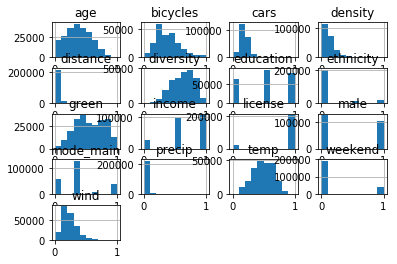

In [14]:
df_scaled.hist()
plt.show()

Para la realización del trabajo de clustering se han seleccionado las características 'distance', 'age' y 'precip', y se han agrupado según la característica 'income'. De esta manera, los datos se agruparán según la distancia, edad y nivel de precipitación con respecto a los ingresos.

/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


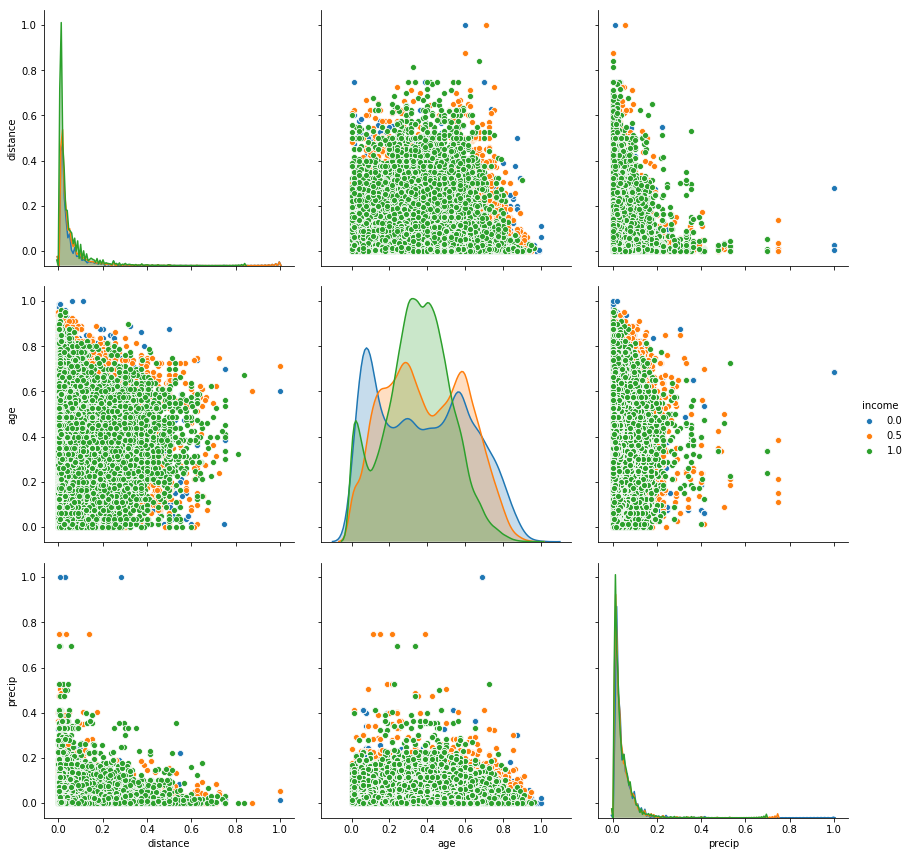

In [15]:
sb.pairplot(df_scaled.dropna(), hue='income',height=4,vars=["distance","age","precip"],kind='scatter')